In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
measure_table = inspect(Measurement)
station_table = inspect(Station)
for column in measure_table.c:
    print (column.name, ":", column.type)
print('\n')
for column in station_table.c:
    print(column.name, ":", column.type)

id : INTEGER
station : TEXT
date : TEXT
prcp : FLOAT
tobs : FLOAT


id : INTEGER
station : TEXT
name : TEXT
latitude : FLOAT
longitude : FLOAT
elevation : FLOAT


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year ago from the last data point in the database
recent_date_string = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)[0].date
year_delta = dt.timedelta(days=365)

year_prior = dt.date.fromisoformat(recent_date_string) - year_delta

In [13]:
# Perform a query to retrieve the data and precipitation scores
data=  [x for x in session.query(Measurement).filter(Measurement.date >= year_prior)]
unzipped_data = {"id": [x.id for x in data], "station": [x.station for x in data], "date": [x.date for x in data], 'precipitation': [x.prcp for x in data], 'tobs': [x.tobs for x in data]}

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(unzipped_data).set_index('date').sort_values(by="date",ascending=False).iloc[::-1]

In [15]:
prcp_series= df['precipitation']

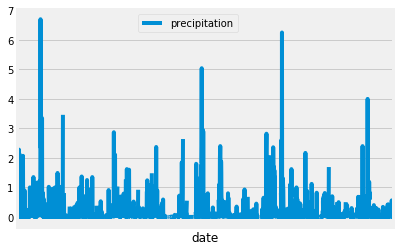

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()

prcp_series.plot(xticks=[]).legend(bbox_to_anchor=(0.6,1))

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_series.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [18]:
![describe](Images/describe.png)

/bin/sh: -c: line 0: syntax error near unexpected token `Images/describe.png'
/bin/sh: -c: line 0: `[describe](Images/describe.png)'


In [19]:
# Design a query to show how many stations are available in this dataset?
len(session.query(Station).distinct().all())

9

In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = df.groupby('station').count()
active

,id,precipitation,tobs
station,,,
USC00513117,343,343,343
USC00514830,305,265,305
USC00516128,349,328,349
USC00517948,183,60,183
USC00519281,352,352,352
USC00519397,361,359,361
USC00519523,337,314,337


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station_name = active.iloc[0].name
active_station = df[df['station'] == active_station_name]
min_temp = active_station['tobs'].min()
max_temp = active_station['tobs'].max()
mean_temp = active_station['tobs'].mean()
print("min:", min_temp)
print("max:", max_temp)
print("mean:", round(mean_temp,1))


min: 60.0
max: 87.0
mean: 75.2


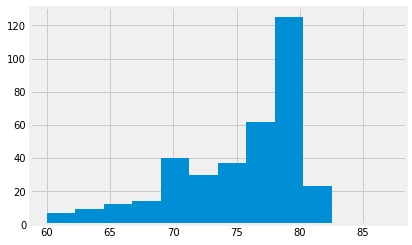

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_df = df[df['station']==active_station_name].reset_index()
active_df.sort_values(by='date', ascending=False, inplace=True)
active_recent_datetime = dt.date.fromisoformat(active_df.iloc[0].date)
active_year_prior = dt.date.isoformat((active_recent_datetime - year_delta))

active_df[active_df['date'] >= active_year_prior]['tobs'].hist(bins=12)


![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
